In [1]:
from collections import OrderedDict

In [2]:
def find_by_key(some, key, curr_key=''):
    type_of_some = type(some)
    if key==curr_key:
        return some
    elif type_of_some == list:
        return [find_by_key(s, key, curr_key='') for s in some]
    elif type_of_some == type(OrderedDict([])):
        return [find_by_key(some[curr_key], key, curr_key) for curr_key in some]
    else:
        return None
    
def flat_list_and_drop_None(some):
    output = []
    for s in some:
        if type(s) == list:
            output.extend(flat_list_and_drop_None(s))
        else:
            if s is not None:
                output.append(s)
    return output

In [236]:
import xmltodict

# macbeth.tei
# romeo.tei.xml
# bernarda.tei.xml
# arrastrarse.tei.xml
# magdalena.tei.xml
with open('romeo.tei.xml', 'r') as f:
    drama_tei = f.read()
    '#text'

drama = []

for act in list(xmltodict.parse(drama_tei)['TEI']['text']['body']['div'])[2:]:
    act_text = []
    for scene in act['div']:
        scene_text = []
        for rep in scene['sp']:
            try:
                speaker = rep['speaker']
    #             print(speaker)
                parts_of_line = flat_list_and_drop_None(find_by_key(rep, '#text'))
                line = '\n'.join(parts_of_line)
                if len(line) > 0:
                    scene_text.append((speaker, line))
            except:
                pass
        act_text.append(scene_text)
    drama.append(act_text)

romeo = drama
romeo[0][0]

[('Benvolio',
  "I pray thee, good Mercutio, let's retire:\nThe day is hot, the Capels are abroad,\nAnd, if we meet, we shall not escape a brawl:\nFor now, these hot days, is the mad blood stirring."),
 ('Mercutio',
  'Thou art like one of these fellows that when he\nenters the confines of a tavern claps me his\nsword upon the table and says “God send me no\nneed of thee!” and by the operation of the second\ncup draws him on the drawer, when indeed there is no\nneed.'),
 ('Benvolio', 'Am I like such a fellow?'),
 ('Mercutio',
  'Come, come, thou art as hot a Jack in thy mood\nas any in Italy, and as soon moved to be moody, and as\nsoon moody to be moved.'),
 ('Benvolio', 'And what to?'),
 ('Mercutio',
  'Nay, an there were two such, we should have none\nshortly, for one would kill the other. Thou! why,\nthou wilt quarrel with a man that hath a hair\nmore, or a hair less, in his beard than thou\nhast: thou wilt quarrel with a man for cracking\nnuts, having no other reason but because th

In [232]:
# draussen.tei.xml
# kasimir
with open('romeo.tei.xml', 'r') as f:
    drama_tei = f.read()
    '#text'

draussen = []

for scene in list(xmltodict.parse(drama_tei)['TEI']['text']['body']['div'])[0:]:
    scene_text = []
    if 'sp' in scene:
        for rep in scene['sp']:
            try:
                speaker = rep['speaker']
    #             print(speaker)
                parts_of_line = flat_list_and_drop_None(find_by_key(rep, '#text'))
                line = '\n'.join(parts_of_line)
                if len(line) > 0:
                    scene_text.append((speaker, line))
            except:
                pass
        draussen.append(scene_text)
    
romeo[0]

[[(OrderedDict([('@xml:id', 'spk-0015'),
                ('w',
                 OrderedDict([('@xml:id', 'fs-rom-0002610'),
                              ('#text', 'SAMPSON')]))]),
   'SAMPSON\nGregory\non\nmy\nword\nwe’ll\nnot\ncarry\ncoals\n,\n.'),
  (OrderedDict([('@xml:id', 'spk-0016'),
                ('w',
                 OrderedDict([('@xml:id', 'fs-rom-0002790'),
                              ('#text', 'GREGORY')]))]),
   'GREGORY\nNo\nfor\nthen\nwe\nshould\nbe\ncolliers\n,\n.'),
  (OrderedDict([('@xml:id', 'spk-0017'),
                ('w',
                 OrderedDict([('@xml:id', 'fs-rom-0002950'),
                              ('#text', 'SAMPSON')]))]),
   'SAMPSON\nI\nmean\nan\nwe\nbe\nin\ncholer\nwe’ll\ndraw\n,\n,\n.'),
  (OrderedDict([('@xml:id', 'spk-0018'),
                ('w',
                 OrderedDict([('@xml:id', 'fs-rom-0003160'),
                              ('#text', 'GREGORY')]))]),
   'GREGORY\nAy\nwhile\nyou\nlive\ndraw\nyour\nneck\nout\nof\ncollar\n,\n,

In [205]:
import numpy as np
import pandas as pd

import tensorflow_hub as hub
import tensorflow_text
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from skimage.transform import resize

import networkx as nx
from node2vec import Node2Vec

import matplotlib.pyplot as plt
import seaborn as sns
import umap
from termcolor import colored


from tqdm.notebook import tqdm
import re
import nltk
import pickle
import swifter
import random

from os import listdir
from os.path import isfile, join
from collections import Counter
from random import randint


def load_all_models(verbose=True):
    cluster_seq_emb = load_model('cluster_seq_emb.h5')
    
    if verbose:
        print('dialog embeder is here')

    with open('kmeans_phrases.pkl', 'rb') as f:
        clust_model_kmeans = pickle.load(f)
    with open('kmeans_phrases_names.pkl', 'rb') as f:
        cluster_names = pickle.load(f)
        
    if verbose:
        print('sent cluster model is here')

    with open('kmeans_seqs.pkl', 'rb') as f:
        ngram_kmeans = pickle.load(f)
    with open('kmeans_seqs_names.pkl', 'rb') as f:
        ngram_clusters_names = pickle.load(f)
    
    if verbose:
        print('dialog cluster model is here')
        
    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")
    if verbose:
        print('thats all')
    
    return cluster_seq_emb, clust_model_kmeans, cluster_names, ngram_kmeans, ngram_clusters_names, embed
    

def getRoundedThresholdv1(a, MinClip):
    return round(float(a) / MinClip) * MinClip


def get_sent_vector(sent):
    return np.array(embed([sent])[0])


def ngrams_from_vec(vec, n=3):
    output = []
    if len(vec) <= n:
        return [[]]
    else:
        return [vec[i: i+n] for i in range(len(vec)-n)]


def final_cluster_text(per_text, cluster_model, cluster_seq_emb, ngram_kmeans, cluster_names={}, sent_to_vector_dict={}):
    output = []
    all_clusters = []
    for person, sent in tqdm(per_text):
        if sent in sent_to_vector_dict:
            sent_vec = sent_to_vector_dict[sent]
        else:
            sent_vec = get_sent_vector(sent)
        if sent_vec is not None:
            cluster =  clust_model_kmeans.predict([sent_vec])[0]
            sents = {sent: cluster_names.get(cluster, str(cluster))}
            output.append((person, sents))
            all_clusters.append(cluster)
    ngrams = ngrams_from_vec(all_clusters, n=3)
    ngrams_text = ngrams_from_vec([sent for _, sent in per_text], n=3)
    ngram_vecs = [cluster_seq_emb.predict([[[clust_model_kmeans.cluster_centers_[cl] for cl in ngram]]])[0][-1] for ngram in ngrams]
    huge_clusters_in_this_text = ngram_kmeans.predict(ngram_vecs)
    return output, all_clusters, huge_clusters_in_this_text, ngrams_text

In [12]:
cluster_seq_emb, clust_model_kmeans, cluster_names, ngram_kmeans, ngram_clusters_names, embed = load_all_models(verbose=True)

dialog embeder is here
sent cluster model is here
dialog cluster model is here
thats all


In [116]:
list(zip(range(210), rudramas))

[(0, 'gogol-lakeiskaja.pkl'),
 (1, 'prutkov-fantaziya.pkl'),
 (2, 'sumarokov-opekun.pkl'),
 (3, 'ostrovsky-bednaja-nevesta.pkl'),
 (4, 'turgenev-mesjats-v-derevne.pkl'),
 (5, 'nekrasov-zabrakovannye.pkl'),
 (6, 'blok-neznakomka.pkl'),
 (7, 'rostopchina-neludimka.pkl'),
 (8, 'sumarokov-pridanoe-obmanom.pkl'),
 (9, 'nekrasov-akter.pkl'),
 (10, 'knyazhnin-rosslav.pkl'),
 (11, 'gogol-zhenitba.pkl'),
 (12, 'kropotov-fomushka.pkl'),
 (13, 'ostrovsky-svoi-sobaki-gryzutsya-chuzhaya-ne-pristavaj.pkl'),
 (14, 'andreyev-mysl.pkl'),
 (15, 'turgenev-holostjak.pkl'),
 (16, 'ostrovsky-trudovoj-hleb.pkl'),
 (17, 'khmelnitsky-vzaimnye-ispytaniya.pkl'),
 (18, 'pushkin-stseny-iz-rytsarskih-vremen.pkl'),
 (19, 'majkov-agriopa.pkl'),
 (20, 'nikolev-samolyubivyj-stihotvorec.pkl'),
 (21, 'fonvizin-korion.pkl'),
 (22, 'zagoskin-blagorodnyj-teatr.pkl'),
 (23, 'gogol-revizor.pkl'),
 (24, 'sumarokov-gamlet.pkl'),
 (25, 'prutkov-chereposlov-sirech-frenolog.pkl'),
 (26, 'khlebnikov-snezhimochka.pkl'),
 (27, 'bulga

In [227]:
parsed_text, _, huge_clusters, ngrams_text = final_cluster_text(rudramas_texts[2][3], 
                                                                clust_model_kmeans,
                                                                cluster_seq_emb,
                                                                ngram_kmeans,
                                                                cluster_names,
                                                                sent_to_vector_dict={})

for ngram_name in [ngram_clusters_names[cl] for cl in huge_clusters]:
    print('{} -> '.format(ngram_name))
print('\n')
i = -2
for person, rep in parsed_text:
    print(person)
    for phrase in rep:
        huge_clusters_for_this_phrase = set([ngram_clusters_names[cl] for cl in huge_clusters[max(0, i): i+3]])
#         print(phrase + ': ' + colored(rep[phrase], 'red') + '\t' + colored(huge_clusters_for_this_phrase, 'green'))
        print(phrase + ': ' + colored(rep[phrase], 'red') + '\t')
    i += 1
    print('\n')


Один/оба говорят о себе, своем положении/действиях -> 
Быт и деньги -> 
Длинные рассуждения на высокие темы -> 
Активное действие -> 
Длинные рассуждения на высокие темы -> 
Длинные рассуждения на высокие темы -> 
Рассуждения на общественные темы -> 
Длинные рассуждения о чувствах/религии/мифологии -> 
Комбинации из коротких вопросов и ответов -> 
Один/оба говорят о себе, своем положении/действиях -> 
Быстрый диалог с короткими эмоциональными фразами -> 
Высказывание различных мнений о людях -> 
Высказывание различных мнений о людях -> 
О движении/местонахождени -> 
О движении/местонахождени -> 
Длинные рассуждения о чувствах/религии/мифологии -> 
Длинные рассуждения о чувствах/религии/мифологии -> 
Длинные рассуждения о чувствах/религии/мифологии -> 
Рассуждения на общественные темы -> 
Быстрый диалог с короткими ответами -> 
Обмен информации, запрос на информацию (о знании) -> 
Один из персонажей говорит, а второй немного вмешивается в диалог -> 
Высказывание различных мнений о людя

In [25]:
rudramas = [f for f in listdir('drama/') if isfile(join('drama/', f))]
rudramas_texts = []


for drama in tqdm(rudramas):
    with open(join('drama/', drama), 'rb') as f:
        rudramas_texts.append(pickle.load(f))

In [64]:
draussen[0][0]

('Der Beerdigungsunternehmer',
 'Aha, da steht einer. Da auf dem Ponton. Sieht aus, als ob er Uniform an hat. Ja, einen\n            alten Soldatenmantel hat er an. Mütze hat er nicht auf. Seine Haare sind kurz wie eine\n            Bürste. Er steht ziemlich dicht am Wasser. Beinahe zu dicht am Wasser steht er da. Das\n            ist verdächtig. Die abends im Dunkeln am Wasser stehn, das sind entweder Liebespaare\n            oder Dichter. Oder das ist einer von der großen grauen Zahl, die keine Lust mehr haben.\n            Die den Laden hinwerfen und nicht mehr mitmachen. Scheint auch so einer zu sein von\n            denen, der da auf dem Ponton. Steht gefährlich dicht am Wasser. Steht ziemlich allein\n            da. Ein Liebespaar kann es nicht sein, das sind immer zwei. Ein Dichter ist es auch\n            nicht. Dichter haben längere Haare. Aber dieser hier auf dem Ponton hat eine Bürste auf\n            dem Kopf. Merkwürdiger Fall, der da auf dem Ponton, ganz merkwürdig.  Rums

In [123]:
for r in huge_clusters_to_text_en[49][1]:
    print(r+'\\\\\n\\indent')

Here is a place reserved, sir.\\
\indent
Where?\\
\indent
Here, my good lord. What is't that moves your highness?\\
\indent


In [78]:
clusters_to_texts_some = {}
huge_clusters_to_text_some = {}

# en - macbeth
# es - arrastrarse
# de - [draussen]

for act in [draussen]:
    for scene in act:
        try:
            parsed_text, clusters, huge_clusters, ngrams_text = final_cluster_text(scene, 
                                                                                   clust_model_kmeans,
                                                                                   cluster_seq_emb,
                                                                                   ngram_kmeans,
                                                                                   cluster_names,
                                                                                   sent_to_vector_dict={})
            for clust, rep in list(zip(clusters, [list(p[1])[0] for p in parsed_text])):
                if clust in clusters_to_texts_some:
                    clusters_to_texts_some[clust] = clusters_to_texts_some[clust] + [rep]
                else:
                    clusters_to_texts_some[clust] = [rep]
                    
            for clust, reps in list(zip(huge_clusters, ngrams_text)):
                if clust in huge_clusters_to_text_some:
                    huge_clusters_to_text_some[clust] = huge_clusters_to_text_some[clust] + [reps]
                else:
                    huge_clusters_to_text_some[clust] = [reps]
        except:
            pass
        
clusters_to_texts_de = clusters_to_texts_some
huge_clusters_to_text_de = huge_clusters_to_text_some

In [81]:
clusters_to_texts = {}
huge_clusters_to_text = {}

for drama in rudramas_texts[100: 110]:
    for scene in drama:
        try:
            parsed_text, clusters, huge_clusters, ngrams_text = final_cluster_text(scene, 
                                                               clust_model_kmeans,
                                                               cluster_seq_emb,
                                                               ngram_kmeans,
                                                               cluster_names,
                                                               sent_to_vector_dict={})
            for clust, rep in list(zip(clusters, [list(p[1])[0] for p in parsed_text])):
                if clust in clusters_to_texts:
                    clusters_to_texts[clust] = clusters_to_texts[clust] + [rep]
                else:
                    clusters_to_texts[clust] = [rep]
                    
            for clust, reps in list(zip(huge_clusters, ngrams_text)):
                if clust in huge_clusters_to_text:
                    huge_clusters_to_text[clust] = huge_clusters_to_text[clust] + [reps]
                else:
                    huge_clusters_to_text[clust] = [reps]
        except:
            pass

In [107]:
clust = 1
print(ngram_clusters_names[clust] + '\n')
for dialog in huge_clusters_to_text[clust][:20]:
    print('\n'.join(dialog))
    print('====================\n'*3)

Комбинация коротких вопросов и ответов

Так не соизволите ли, ваше высокорейсграфское превосходительство, хотя рюмочку
              рейнского или церковного?
Нет, сударыня, благодарствую.
Ин медку или бражки?

Ин медку или бражки?
Нет, сударыня.
Так чем же такого дорогого гостя потчевать?

Как же без этого?
Милости просим, высокосиятельнейший граф, отведать нашей хлеба-соли.
Выметена ли у нас горница?

Хавронья, так ли это?
Што я табе, красное мое солнышко, верна, это правда, а што граф берет ее за себя, это
              я и сама теперь только слышу. Дай Бог ей счастие! А она этого достойна.
Достойно и праведно.

Он старый?
Нет, ничего. Самое большее, лет сорок, сорок пять. По-видимому, славный малый. Неглуп, это – несомненно. Только говорит много.
Интересный человек?

Ты ведешь себя на три с минусом.
А наливка вкусная. На чем это настоено?
На тараканах.

А наливка вкусная. На чем это настоено?
На тараканах.
Фу! Фу! Какое отвращение!..

Ты что, Наташа?
Смотрю, огня нет ли... Теперь м

In [82]:
{clust: ngram_clusters_names[clust] for clust in
set(huge_clusters_to_text_en).intersection(set(huge_clusters_to_text_es)).intersection(set(huge_clusters_to_text_de))}

{2: 'Рассуждения на общественные темы',
 4: 'Комбинация из коротких вопросов и ответов',
 6: 'Длинные рассуждения о чувствах/религии/мифологии',
 40: 'Быстрый диалог с короткими ответами',
 16: 'Активное действие',
 22: 'Короткие фразы, высказывания о себе/других людях',
 29: 'Кто-то говорит о себе'}

In [223]:
clust = 11
# print('ru')
# for rep in clusters_to_texts[clust][:10]:
#     print(rep)

# print('es')
# for rep in clusters_to_texts_es[clust][:10]:
#     print(rep)
    
# print('de')
# for rep in clusters_to_texts_de[clust][:10]:
#     print(rep)
    
print('en')
for rep in clusters_to_texts_en[clust][:10]:
    print(rep)

en
Hold, take my sword. There's husbandry in heaven;
Their candles are all out. Take thee that too.
A heavy summons lies like lead upon me,
And yet I would not sleep: merciful powers,
Restrain in me the cursed thoughts that nature
Gives way to in repose! 
              
              Give me my sword.
Who's there?
That which hath made them drunk hath made me bold;
What hath quenched them hath given me fire.
Hark! Peace!
It was the owl that shrieked, the fatal bellman,
Which gives the stern'st good-night. He is about it:
The doors are open; and the surfeited grooms
Do mock their charge with snores: I have drugged their possets,
That death and nature do contend about them,
Whether they live or die.
One cried “God bless us!” and “Amen” the other;
As they had seen me with these hangman's hands.
Listening their fear, I could not say “Amen,”
When they did say “God bless us!”
Methought I heard a voice cry “Sleep no more!
Macbeth does murder sleep,” the innocent sleep,
Sleep that knits up the 

In [126]:
len(huge_clusters_to_text)

50

In [119]:
clust = 49
print('ru')
for rep in huge_clusters_to_text[clust][0]:
    print('\n' + rep)
print('\n=================================\n')
print('es')
for rep in huge_clusters_to_text_es[clust][1]:
    print('\n' + rep)
print('\n=================================\n')    
print('de')
for rep in huge_clusters_to_text_de[clust][0]:
    print('\n' + rep)
print('\n=================================\n')    
print('en')
for rep in huge_clusters_to_text_en[clust][0]:
    print('\n' + rep)

ru

Решетчаты-е!

Черт возьми, давайте выпьем. Андрюша, давайте выпьем на ты. И я с тобой, Андрюша, в
              Москву, в университет.

В какой? В Москве два университета.


es

¡Su nombre!

tío Lesmes
¡El !

tío Lesmes
tío Lesmes
¡El ! ¿Ha estado aquí el ?... ¿Pero dónde está, dónde?


de


KeyError: 49

In [245]:
romeo_pic = []

for act in romeo:
    for scene in act:
        try:
            parsed_text, clusters, huge_clusters, ngrams_text = final_cluster_text(scene, 
                                                                                   clust_model_kmeans,
                                                                                   cluster_seq_emb,
                                                                                   ngram_kmeans,
                                                                                   cluster_names,
                                                                                   sent_to_vector_dict={})
            if len(clusters) > 0:
                part_vec = list(np.sum([to_categorical(cl, 50) for cl in clusters], axis=0))
                romeo_pic.append(list(normalize([part_vec])[0]))
        except:
            pass
    
romeo_pic = resize(np.array(romeo_pic), (5, 50))

In [252]:
r_m_pic = list(romeo_pic) + [([0.0] * 50)] + list(macbeth_pic)

In [258]:
cluster_names[36] = 'Отрицательный ответ/восклицание'
cluster_names


{0: 'Вопрос',
 1: 'Эмоциональное высказывание',
 2: 'Действие/призыв к действию',
 3: 'Брат/сестра',
 4: 'Высказывание о себе или других людях',
 5: 'Короткий ответ',
 6: 'Хозяйство/еда/время',
 7: 'Шутки/смех/обида',
 8: 'Вера/обещание/прощение',
 9: 'Вопрос(может эмоциональный)',
 10: 'Молчание/разговор',
 11: 'Чувство/религия/мифология',
 12: '"Вижу"(описание/вопрос)',
 13: 'Эмоциональное восклицание',
 14: 'Короткий ответ',
 15: 'Короткий ответ с отрицательной частицей',
 16: 'Эмоциональное высказывние/вопрос',
 17: 'Фраза с троеточием(эмоция)',
 18: 'Благодарность/радость/поздравление',
 19: 'Короткий вопрос',
 20: 'Обращение по имени отчеству',
 21: 'Быт/передвижения',
 22: 'Князь/царь/король/власть',
 23: 'Мнение/действие',
 24: 'Семейный отношения(Бог как отец)',
 25: 'Короткая фраза с троеточием',
 26: 'О знании ;',
 27: 'О женщине',
 28: 'О действии',
 29: 'О передвижении',
 30: 'Свадьба/жених/невеста',
 31: 'К матери/о матери',
 32: 'Эмоциональное высказывание',
 33: 'О день

Чувство/религия/мифология
Чувство/религия/мифология
Чувство/религия/мифология
Чувство/религия/мифология
Чувство/религия/мифология


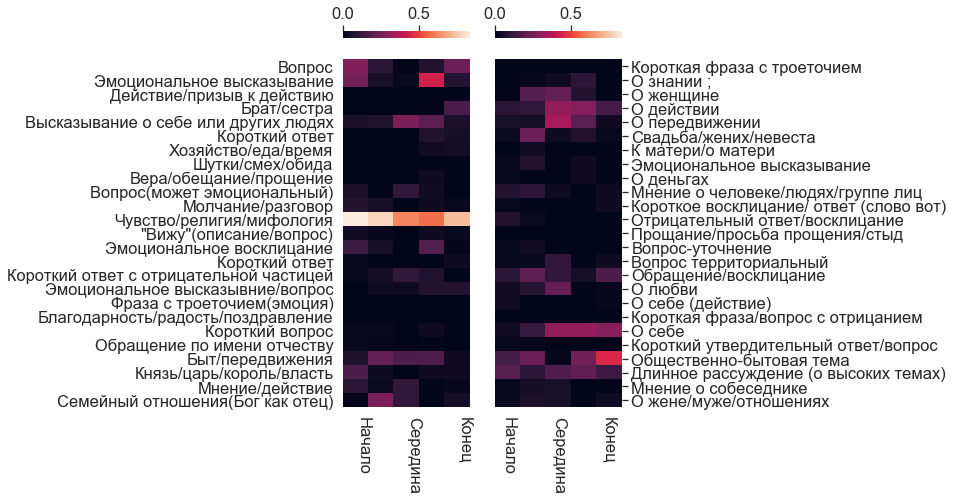

<Figure size 432x288 with 0 Axes>

In [273]:
drama_pic_to_draw = romeo_pic
sns.set(font_scale=1.5)
for theme in [cluster_names[np.argmax(line)] for line in drama_pic_to_draw]:
    print(theme)
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(5, 8)
cl_names_list = [v for _, v in sorted(cluster_names.items(), key=lambda item: item[0])]
max_value = np.max(normalize(drama_pic_to_draw))
hm = sns.heatmap(np.transpose(normalize(drama_pic_to_draw))[:25],
            yticklabels=cl_names_list[:25],
            xticklabels=['Начало', '', 'Середина', '' , 'Конец'], ax=axes[0], 
            vmin=.0, vmax=max_value, cbar_kws = dict(use_gridspec=False,location="top"))
hm.set_xticklabels(hm.get_xticklabels(), rotation=270, horizontalalignment='left')
hm.set_yticklabels(hm.get_yticklabels(), rotation=0, horizontalalignment='right')

hm = sns.heatmap(np.transpose(normalize(drama_pic_to_draw))[25:],
            yticklabels=cl_names_list[25:],
            xticklabels=['Начало', '', 'Середина', '' , 'Конец'], ax=axes[1],
            vmin=.0, vmax=max_value, cbar_kws = dict(use_gridspec=False,location="top"))
hm.set_xticklabels(hm.get_xticklabels(), rotation=270, horizontalalignment='center')
hm.set_yticklabels(hm.get_yticklabels(), rotation=0, horizontalalignment='left')
hm.yaxis.tick_right()
plt.show()
plt.clf()

In [271]:
cluster_names[45] = 'Короткий утвердительный ответ/вопрос'

In [195]:
for rep in huge_clusters_to_text[49][1]:
        print('-- {} \\\\'.format(rep))

-- Ряженые! \\
-- Скажи, нянечка, дома нет никого. Пусть извинят. \\
-- Никого нет... А где же все? \\


In [191]:
ngram_clusters_names

{19: 'Диалог о семье/любви/свадьбе',
 33: 'Диалог из вопросов и ответов (в основном вопрос-ответ-вопрос)',
 7: 'Один из персонажей говорит, а второй немного вмешивается в диалог',
 11: 'Обмен информации, запрос на информацию (о знании)',
 21: 'Разговор о матери/с матью',
 18: 'Разговор о том что можно/нельзя или возможно/невозможно',
 42: 'О свадьбе',
 16: 'Активное действие',
 13: 'Один/оба говорят о себе, своем положении/действиях',
 6: 'Длинные рассуждения о чувствах/религии/мифологии',
 14: 'Комбинации из коротких вопросов и ответов',
 30: 'Шутки/смех/обида',
 44: 'Комбинации из коротких вопросов и ответов',
 0: 'Про передвижение в пространстве (в основном короткие фразы)',
 8: 'Комбинации из коротких вопросов и ответов',
 4: 'Комбинация из коротких вопросов и ответов',
 27: 'Длинные диалоги про общество/страну/общественное положение/работу/быт',
 48: 'Описания',
 36: 'Быстрое действие (короткие и эмоциональные фразы)',
 25: 'Рассказ о себе/других людях',
 26: 'Диалог, где один из 

In [136]:
for clust in range(50):
    print(clust)
    print('Название кластера: {}\\\\'.format(ngram_clusters_names[clust]))
    print('Пример: \\\\' )
    for rep in huge_clusters_to_text[clust][0]:
        print('-- {} \\\\'.format(rep))
    print('\n\n')

0
Название кластера: Про передвижение в пространстве (в основном короткие фразы)\\
Пример: \\
-- На Старой Басманной. \\
-- И мы там тоже... \\
-- Одно время я жил на Немецкой улице. С Немецкой улицы я хаживал в Красные казармы. Там
              по пути угрюмый мост, под мостом вода шумит. Одинокому становится грустно на душе. А Здесь какая широкая, какая богатая река! Чудесная река! \\



1
Название кластера: Комбинация коротких вопросов и ответов\\
Пример: \\
-- Так не соизволите ли, ваше высокорейсграфское превосходительство, хотя рюмочку
              рейнского или церковного? \\
-- Нет, сударыня, благодарствую. \\
-- Ин медку или бражки? \\



2
Название кластера: Рассуждения на общественные темы\\
Пример: \\
-- Фу, матка, какая любопытная. \\
-- Конечно, ты балагур? \\
-- А ты, душенька, так хороша, что я едаких хорошеньких мало видал. Знаешь ли ты,
              девушка, что я в тебя смертно влюбился. \\



3
Название кластера: Длинные рассуждения на высокие темы\\
Пример: \\
-

In [125]:
for clust in range(50):
    text = ' '.join(clusters_to_texts[clust][0].split('\n'))
    print('{}&{}\\\\ \\hline'.format(cluster_names[clust], text[:300]))

Вопрос&Я прислан от графа Касандра к вашему сия... к вашему превосхо... к вашему высоко...               Какого, сударь, вы чина?\\ \hline
Эмоциональное высказывание&Говори, друг мой, то, зачем ты прислан, покороче.\\ \hline
Действие/призыв к действию&Откажу, откажу...\\ \hline
Брат/сестра&Что тебе, братец, до моего чина? Какого ни есть.\\ \hline
Высказывание о себе или других людях&А ты, душенька, так хороша, что я едаких хорошеньких мало видал. Знаешь ли ты,               девушка, что я в тебя смертно влюбился.\\ \hline
Короткий ответ&Имеется.\\ \hline
Хозяйство/еда/время&Да водочка та, ваша высокорейсграфская светлость, самая знатная и богатая.\\ \hline
Шутки/смех/обида&У тебя, Ниса, ушки смеются.\\ \hline
Вера/обещание/прощение&Мы и сердца наши закрыты! Я вам верю, да поверьте и мне, что и я не меньше к вам               усердия имею.\\ \hline
Вопрос(может эмоциональный)&Что ты, друг мой?\\ \hline
Молчание/разговор&Пора мне идти к барам, скоро барыня встанет. Так что же мне о тебе 

In [91]:
es_clust = '''¿Y cómo te lo dijo?
¡Lo que digo!
¿Hay que decir las cosas dos veces? ¡Echadlo que se revuelque en los montones de paja!  Pues encerrad las potras en la cuadra, pero dejadlo libre, no sea que nos eche abajo las paredes.  ¡Ay, qué vida!
yo no quiero hablar porque temo tus intenciones. Pero no estés segura.
Hay quien cree que habló muchas noches con .
Ha llegado el momento de que yo hable. Esto no puede seguir así.
¿Ha oído usted contar?  No recuerdo...  No hablemos de eso: cosas de la juventud. (Pues no sé a qué podrá referirse.)
Dice  que deseaba usted hablarme.
Es verdad; todavía no he dicho lo que tenía que decir.
Haz lo que quieras, pero silencio.'''

en_clust = '''I heard the owl scream and the crickets cry.
Did not you speak?
Well, let's away, and say how much is done.
Say, if th' hadst rather hear it from our mouths,
Or from our masters?
He knows thy thought:
Hear his speech, but say thou nought.
Listen, but speak not to't.
With what I get, I mean; and so do they.
If such a one be fit to govern, speak:
I am as I have spoken.
Be not a niggard of your speech: how goes't?'''

de_clust = '''Na muaß i d' wahrheit drauß'n hör'n.'''

ru_clust = '''Покойной, вам легко сказать!
Но скажите мне, скажите, что вы не в состоянии оскорбить женщину.
И ни слова мне не скажете?
Вы меня не увидите более… Я вам говорю — я не переживу этой ночи.
Скажи, правду, умоляю тебя, скажи мне правду…
Пора мне идти к барам, скоро барыня встанет. Так что же мне о тебе сказать?
Да ты не в слове, да в деле промолвилася.
Дело больше, а слово меньше.
Ваше сиятельство, вы темно говорите и делаете не знаю какие намеки, которых я не понимаю.
Позволите ли мне яснее выговорить.'''

In [92]:
print('\\hline')
print('{}&{}&{}&{}\\\\ \\hline'.format('Русский', 'Испанский', 'Немецкий', 'Анкглийский'))
for i in range(1):
    ru = ru_clust if len(ru_clust) > i else ''
    es = es_clust if len(es_clust) > i else ''
    de = de_clust if len(de_clust) > i else ''
    en = en_clust if len(en_clust) > i else ''
    print('{}&{}&{}&{}\\\\'.format(ru, es, de, en))
print('\\hline')

\hline
Русский&Испанский&Немецкий&Анкглийский\\ \hline
Покойной, вам легко сказать!
Но скажите мне, скажите, что вы не в состоянии оскорбить женщину.
И ни слова мне не скажете?
Вы меня не увидите более… Я вам говорю — я не переживу этой ночи.
Скажи, правду, умоляю тебя, скажи мне правду…
Пора мне идти к барам, скоро барыня встанет. Так что же мне о тебе сказать?
Да ты не в слове, да в деле промолвилася.
Дело больше, а слово меньше.
Ваше сиятельство, вы темно говорите и делаете не знаю какие намеки, которых я не понимаю.
Позволите ли мне яснее выговорить.&¿Y cómo te lo dijo?
¡Lo que digo!
¿Hay que decir las cosas dos veces? ¡Echadlo que se revuelque en los montones de paja!  Pues encerrad las potras en la cuadra, pero dejadlo libre, no sea que nos eche abajo las paredes.  ¡Ay, qué vida!
yo no quiero hablar porque temo tus intenciones. Pero no estés segura.
Hay quien cree que habló muchas noches con .
Ha llegado el momento de que yo hable. Esto no puede seguir así.
¿Ha oído usted contar?